# Introduction
In this challenge you'll be taking the given dataset and working with predictive models to make certain inferences about it. This will be much more free form than the labs you've seen each week, but we decided to have this challenge on Google Colab, since its a familiar platform.

# Data

The dataset can be found [here](https://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/). Note that you must have a 90/10 train/test split with this data!

The data is composed from a total of 27370 fish images taken from underwater live video. It contains 23 classes that represent different species of fish. 

![An image](https://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/images/gt_labels.png)


The data is organised in 23 files, each containing a single class. The distribution of the images by class is as follows:

Number | Species | Count
--- | --- | ---
 01 | Dascyllus reticulatus  |	 12112  
 02 | Plectroglyphidodon dickii | 	 2683 
 03 | Chromis chrysura  |	 3593 
 04 | Amphiprion clarkii  |	 4049 
 05 | Chaetodon lunulatus  |	 2534 
 06 | Chaetodon trifascialis  |	 190 
 07 | Myripristis kuntee  |	 450 
 08 | Acanthurus nigrofuscus  |	 218 
 09 | Hemigymnus fasciatus  |	 241 	
 10 | Neoniphon sammara   |	 299 	
 11 | Abudefduf vaigiensis  |	 98 
 12 | Canthigaster valentini  |	 147 
 13 | Pomacentrus moluccensis  |	 181 
 14 | Zebrasoma scopas  |	 90 
 15 | Hemigymnus melapterus  |	 42 
 16 | Lutjanus fulvus  |	 206 
 17 | Scolopsis bilineata  |	 49 
 18 | Scaridae   |	 56 
 19 | Pempheris vanicolensis   |	 29 
 20 | Zanclus cornutus  |	 21 
 21 | Neoglyphidodon nigroris   |	 16 
 22 | Balistapus undulatus  | 	 41 
 23 | Siganus fuscescens   |	 25 	

Each image is named as "tracking id_fish id". The tracking id refers to the fish trajectory, so images sharing this id have the same fish. The fish id is unique for each image and ranges from 1 to 27370. 


# What is expected?

There are 3 primary tasks we'd like you to address with this data:

1. (4 pts) Data augmentation and cleaning. Take some time to sift through a bunch of the images, and see if there are useful changes you could make to them. Consider transformations you could use on images to increase the number of datapoints for particular categories.
2. (4 pts) Explore models to make inferences on the data. We are primarily looking for models that predict fish species given an image. You are welcome to work with models that do other things, but those should be done after making a classification model. Consider the different models you could use. If you decide to use a neural net, consider different options for the architecture, learning rate, activation functions, and other hyperparameters. These will likely have a large impact on your results!
3. (4 pts) Visualize what your model has learned in some way (hint: If you used a CNN, try plotting some of the learned convolutional filters). Can you make inferences about what the model learned or how? Take this time to also make some plots pertaining to accuracy. Feel free to dip into methods we didn't cover in the course, e.g. AUC, cross validation, etc.
4. (Bonus 4 pts) Produce a writeup of your results. While this step is optional, it is highly reccomended. In the field of Machine Learning and Data Science, it is incredibly important to be able to communicate your ideas and results to others. This is excellent practice for the real world, but it also is a way to demonstrate to potential employers your ability to communicate complex ideas! Here's what we'd hope for in a writeup: 

  a) A short description of the problem you tackled, why it may be important or useful, and the results. (1-2 paragraphs)

  b) A description of how and why you modified the data. (1-2 paragraphs)

  c) An explanation of the models you tried out that showed promise, as well as the final model you chose to use. Assume the reader has a basic understanding of how these models may work. If you use methods not covered in the course (e.g. attention, generative models, etc), then explain these methods in a few sentences so the reader knows the basic idea behind it. (2-3 paragraphs)

  d) Conclude by discussing the results you got. Who could use this information or model to solve a problem? (1 paragraph)



Note that the description for step 4 is just a set of reccomendations! You don't have to strictly adhere to the paragraph reccomendations, and you can cover more or less content in your write up. However you should treat the description as your baseline with which to work off of.


Lastly, we will award additional points based on the accuracy of your model. The additional points will be given as (% correct based on our testing)*4pts.


Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
 
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
 
import pathlib

Lets download the data
The folder structure is as follows
```
Fish
Class_01/
Class_02/
Class_N/
```


In [2]:
fish_data_set_url = "https://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar"
fish_image_directory = tf.keras.utils.get_file('fish_image', origin=fish_data_set_url, untar=True)
fish_image_directory = pathlib.Path(fish_image_directory)

510918656/510912000 [==============================] - 25s 0us/step


Helper function to get Class name given id

In [3]:
classes = {
'fish_01':'Dascyllus reticulatus',
'fish_02':'Plectroglyphidodon dickii',
'fish_03':'Chromis chrysura',
'fish_04':'Amphiprion clarkii',
'fish_05':'Chaetodon lunulatus',
'fish_06':'Chaetodon trifascialis',
'fish_07':'Myripristis kuntee',
'fish_08':'Acanthurus nigrofuscus',
'fish_09':'Hemigymnus fasciatus',
'fish_10':'Neoniphon sammara',
'fish_11':'Abudefduf vaigiensis',
'fish_12':'Canthigaster valentini',
'fish_13':'Pomacentrus moluccensis',
'fish_14':'Zebrasoma scopas',
'fish_15':'Hemigymnus melapterus',
'fish_16':'Lutjanus fulvus',
'fish_17':'Scolopsis bilineata',
'fish_18':'Scaridae',
'fish_19':'Pempheris vanicolensis',
'fish_20':'Zanclus cornutus',
'fish_21':'Neoglyphidodon nigroris',
'fish_22':'Balistapus undulatus',
'fish_23':'Siganus fuscescens'
}
 
print(classes['fish_01'])

Dascyllus reticulatus


Lets inspect the data that we have.

In [4]:
batch_size = 32
img_height = 150
img_width = 150
 
train_data_set  = tf.keras.preprocessing.image_dataset_from_directory(
  fish_image_directory,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27370 files belonging to 23 classes.
Using 24633 files for training.


In [5]:
class_names = train_data_set.class_names
print(class_names)

['fish_01', 'fish_02', 'fish_03', 'fish_04', 'fish_05', 'fish_06', 'fish_07', 'fish_08', 'fish_09', 'fish_10', 'fish_11', 'fish_12', 'fish_13', 'fish_14', 'fish_15', 'fish_16', 'fish_17', 'fish_18', 'fish_19', 'fish_20', 'fish_21', 'fish_22', 'fish_23']


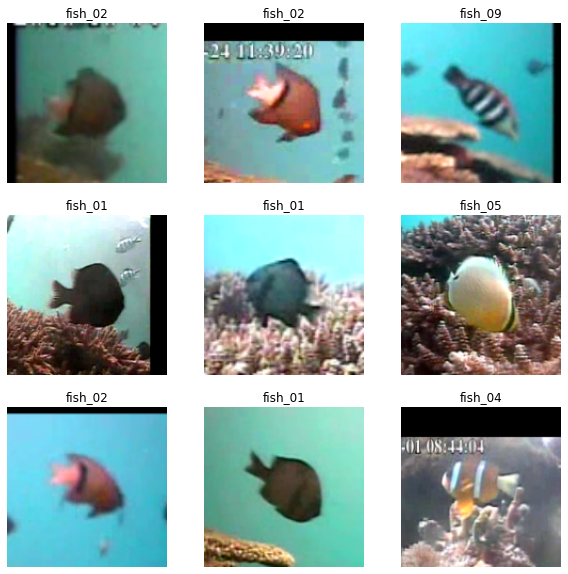

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
testing_data_set = tf.keras.preprocessing.image_dataset_from_directory(
  fish_image_directory,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
 
number_of_classes = len(class_names)

Found 27370 files belonging to 23 classes.
Using 2737 files for validation.


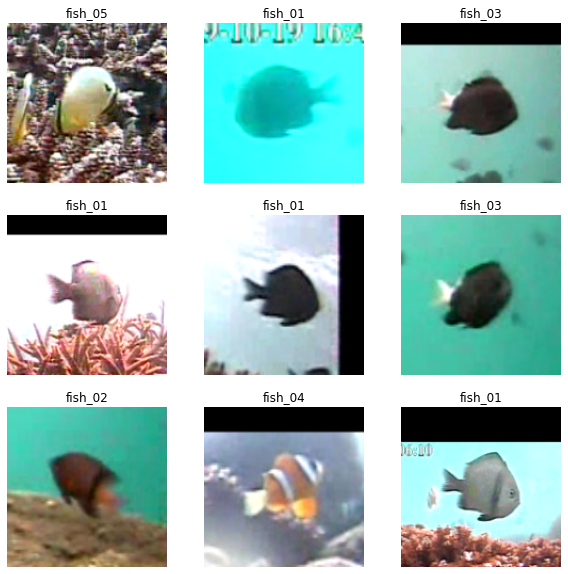

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in testing_data_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Optimize performance

In [9]:
image_buffer_size = 32
 
print(image_buffer_size)
 
train_data_set = train_data_set.cache().shuffle(1000).prefetch(buffer_size=image_buffer_size)
testing_data_set = testing_data_set.cache().prefetch(buffer_size=image_buffer_size)

32


Data Augmentation

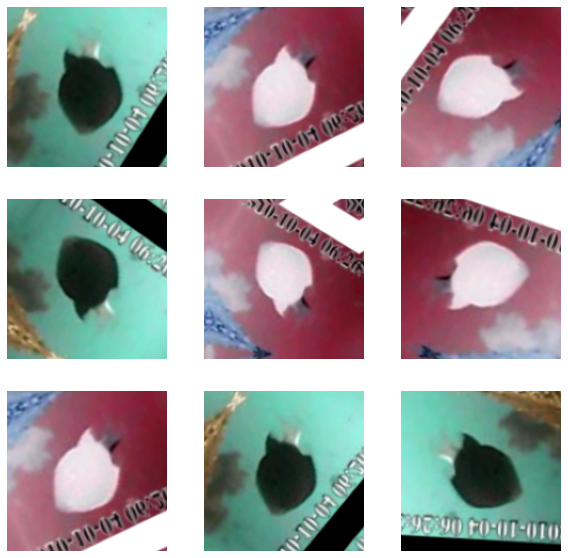

In [10]:
#Lets Change Color and Saturation
 
@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
 
# grayscaled = tf.image.rgb_to_grayscale(image)
# visualize(image, tf.squeeze(grayscaled))
 
@tf.function
def grayscale(x):
  augmented = tf.image.rgb_to_grayscale(x)
  return tf.squeeze(augmented);
 
data_augmentation = keras.Sequential([
                                      
                                      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
                                      layers.experimental.preprocessing.RandomRotation(0.5),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
                                      layers.Lambda( lambda x : random_invert_img(x)),
                                      # layers.Lambda( lambda x : grayscale(x) ),
                                      ])
 
plt.figure(figsize=(10,10))
for images, _ in train_data_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

The Model

In [12]:
classifier_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(number_of_classes)
])
 
 
sgd = SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)

Compile the model

In [14]:
classifier_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"]
              )
 
# classifier_model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
 
classifier_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)      

Load Model from checkpoint

In [ ]:
# path to saved model ./model path
classifier_model.load_weights("saved_at_epoch_20.h5")

Lets try and understand the filters in the model

In [16]:
layer = classifier_model.layers #Conv layers at 2,4,5,7,9
print(layer)

[<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fcfb577c610>, <tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fcfb522c5d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcfb522c790>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcfb52a67d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcfb52a6350>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcfb530fa90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcfb530fdd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcfb530f510>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcfb530f190>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcfb570fa10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcfb53086d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcfb5b2d6d0>, <tensorflow.pyt

In [17]:
filters, biases = classifier_model.layers[2].get_weights()
print(layer[2].name, filters.shape)

conv2d_5 (3, 3, 3, 32)


IndexError: ignored

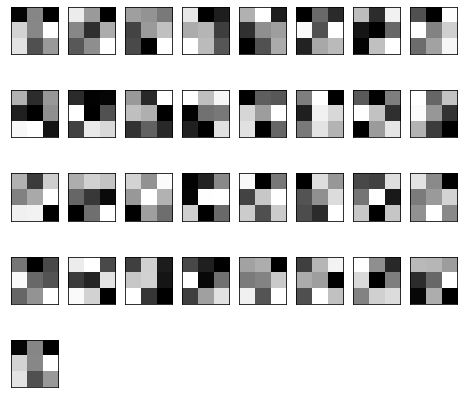

In [22]:
# plot filters
 
fig1=plt.figure(figsize=(8, 12))
columns = 8
rows = 8
n_filters = columns * rows
for i in range(1, n_filters -1):
    f = filters[:, :, :, i -2 ]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()

Train the model

In [ ]:
epochs = 20
 
callbacks = [
    keras.callbacks.ModelCheckpoint("saved_at_epoch_{epoch}.h5"),
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]
 
history = classifier_model.fit(
  train_data_set,
  validation_data=testing_data_set,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/10
770/770 [==============================] - 29s 38ms/step - loss: 0.1082 - accuracy: 0.9675 - val_loss: 0.1141 - val_accuracy: 0.9689
Epoch 2/10
770/770 [==============================] - 30s 39ms/step - loss: 0.1110 - accuracy: 0.9670 - val_loss: 0.1113 - val_accuracy: 0.9686
Epoch 3/10
770/770 [==============================] - 30s 39ms/step - loss: 0.1101 - accuracy: 0.9662 - val_loss: 0.1196 - val_accuracy: 0.9693
Epoch 4/10
770/770 [==============================] - 30s 39ms/step - loss: 0.1008 - accuracy: 0.9699 - val_loss: 0.0897 - val_accuracy: 0.9766
Epoch 5/10
770/770 [==============================] - 30s 39ms/step - loss: 0.1029 - accuracy: 0.9678 - val_loss: 0.1725 - val_accuracy: 0.9507
Epoch 6/10
770/770 [==============================] - 30s 39ms/step - loss: 0.1067 - accuracy: 0.9672 - val_loss: 0.1085 - val_accuracy: 0.9682
Epoch 7/10
770/770 [==============================] - 30s 39ms/step - loss: 0.0994 - accuracy: 0.9707 - val_loss: 0.1130 - val_accuracy:

Accuracy Plot

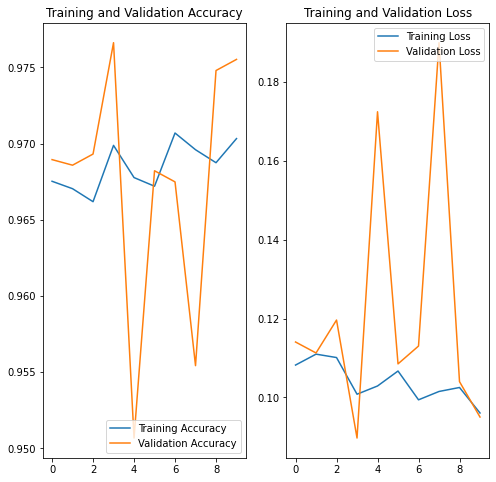

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(epochs)
 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Lets test the model

122880/117660 [===============================] - 0s 2us/step
/root/.keras/datasets/test_fish_image3


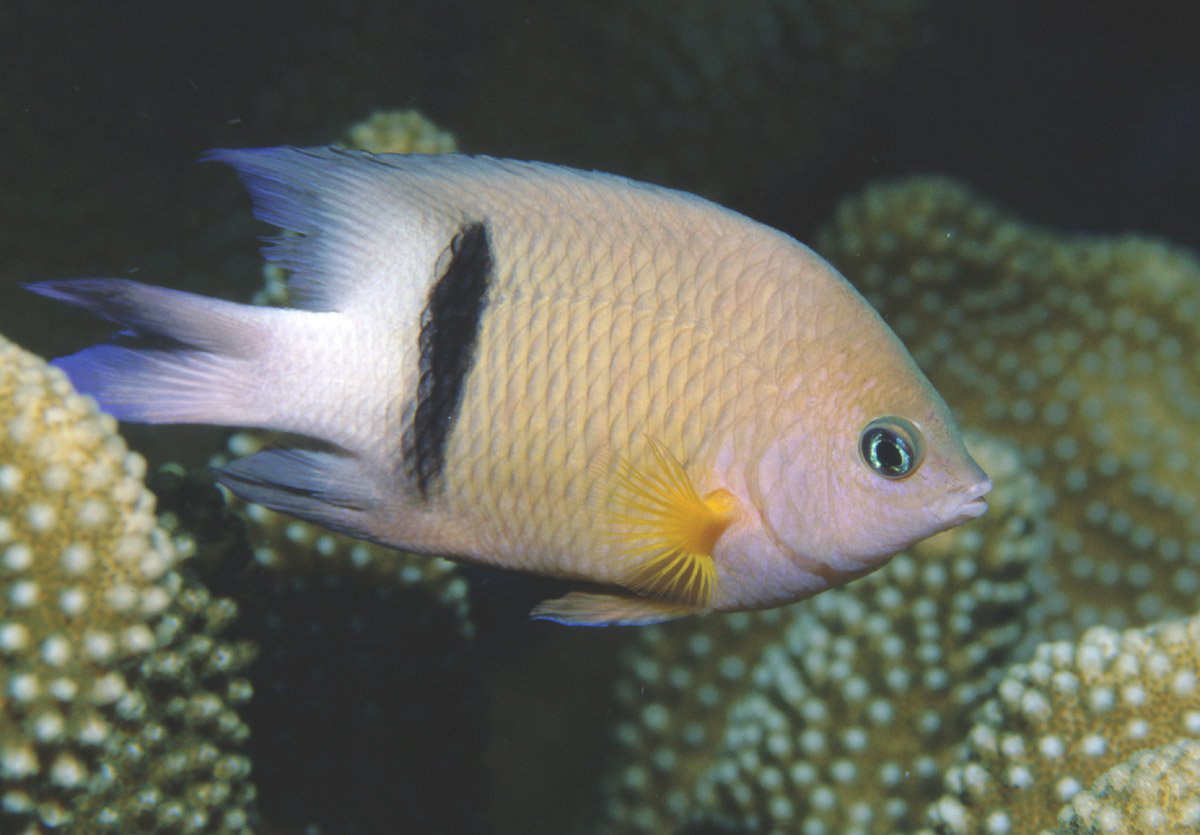

In [ ]:
test_image = "https://media.australian.museum/media/dd/images/Some_image.width-1200.cff8c2e.jpg"
test_path = tf.keras.utils.get_file('test_fish_image3', origin=test_image)
 
print(test_path)
PIL.Image.open(test_path)

In [ ]:
img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
 
 
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
 
predictions = classifier_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
 
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[class_names[np.argmax(score)]], 100 * np.max(score))
)

This image most likely belongs to Chaetodon lunulatus with a 89.62 percent confidence.
